In [2]:
%matplotlib inline
import numpy as np
import skimage
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os
import scipy.misc as sm
from scipy import ndimage


In [6]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def load_data(dir_name = '/content/faces_imgs'):    
    '''
    Load images from the "faces_imgs" directory
    Images are in JPG and we convert it to gray scale images
    '''
    imgs = []
    for filename in os.listdir(dir_name):
        if os.path.isfile(dir_name + '/' + filename):
            img = mpimg.imread(dir_name + '/' + filename)
            img = rgb2gray(img)
            imgs.append(img)
    return imgs


def visualize(imgs, format=None, gray=False):
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(2, 2, plt_idx)
        plt.imshow(img, format)
    plt.show()

In [7]:
class cannyEdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
        return 
    
    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g
    
    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.filters.convolve(img, Kx)
        Iy = ndimage.filters.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)
    

    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z

    def threshold(self, img):

        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def hysteresis(self, img):

        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img
    
    def detect(self):
        imgs_final = []
        for i, img in enumerate(self.imgs):    
            self.img_smoothed = convolve(img, self.gaussian_kernel(self.kernel_size, self.sigma))
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            self.imgs_final.append(img_final)

        return self.imgs_final

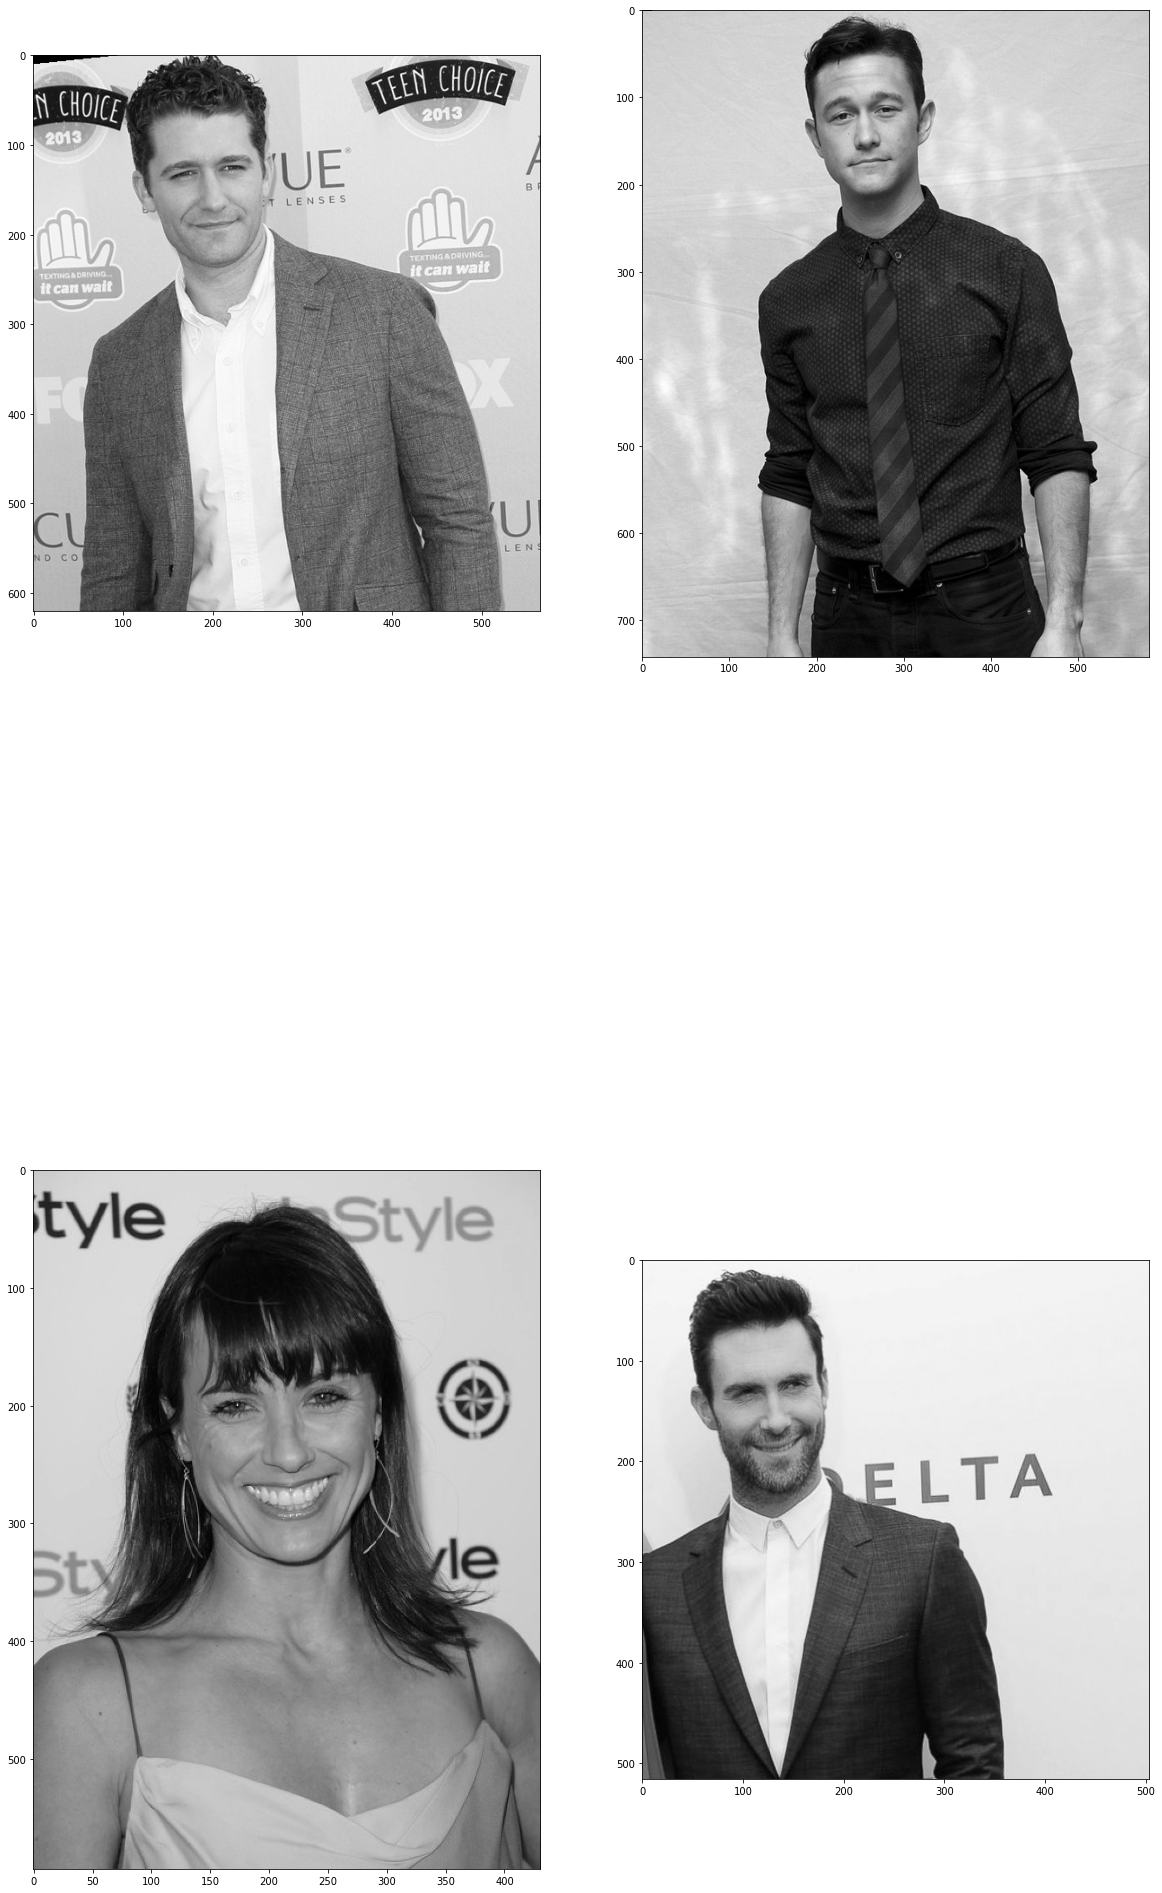

In [8]:
imgs = load_data()
visualize(imgs, 'gray')

In [9]:
detector = cannyEdgeDetector(imgs, sigma=1.4, kernel_size=5, lowthreshold=0.09, highthreshold=0.17, weak_pixel=100)